In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.langid_crf import *
from helper.dataset_reader import read_tsv
from deep_learning_models import *

In [2]:
from tensorflow.python.client import device_lib

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.0
GPU detected: []


In [3]:
data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

In [4]:
all_data, words, tags = data

In [5]:
len(words)

133790

In [6]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [7]:
unique_words = list(set(df_wordtag['Token'].values))
unique_words.append("ENDPAD")
num_words = len(unique_words)
print(num_words)

26890


In [8]:
tags = list(set(df_wordtag["Label"].values))
print(tags)
num_tags = len(tags)
print(num_tags)

['ID', 'JV', 'MIX-ID-EN', 'EN', 'MIX-JV-EN', 'O', 'MIX-ID-JV']
7


In [9]:
dt_pair = to_token_tag_list(data)
# dt_pair[0]

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

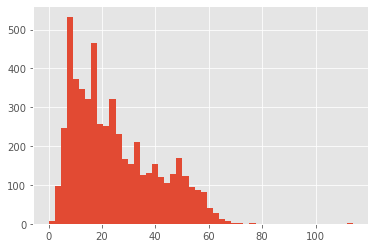

In [11]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 7)            1407      
 ibuted)                                                         
                                                             

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [18]:
%%time

chkpt = ModelCheckpoint("../model/model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'model/embedding/embedding_lookup' defined at (most recent call last):
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-18-21847a89921d>", line 1, in <module>
      get_ipython().run_cell_magic('time', '', '\nchkpt = ModelCheckpoint("../model/model_weights.h5", monitor=\'val_loss\',verbose=1, save_best_only=True, save_weights_only=True, mode=\'min\')\n\nearly_stopping = EarlyStopping(monitor=\'val_accuracy\', min_delta=0, patience=2, verbose=0, mode=\'max\', baseline=None, restore_best_weights=False)\n\ncallbacks = [PlotLossesCallback(), chkpt, early_stopping]\n\nhistory = model.fit(\n    x=x_train,\n    y=y_train,\n    validation_data=(x_test,y_test),\n    batch_size=32,\n    epochs=50,\n    callbacks=callbacks,\n    verbose=1\n)\n')
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2399, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/decorator.py", line 231, in fun
      return caller(func, *(extras + args), **kw)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magic.py", line 187, in <lambda>
      call = lambda f, *a, **k: f(*a, **k)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 7, in <module>
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/embedding/embedding_lookup'
indices[24,0] = 52627 is not in [0, 26890)
	 [[{{node model/embedding/embedding_lookup}}]] [Op:__inference_train_function_6190]

In [19]:
model.evaluate(x_test, y_test)

InvalidArgumentError: Graph execution error:

Detected at node 'model/embedding/embedding_lookup' defined at (most recent call last):
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-19-113a54cbdef7>", line 1, in <module>
      model.evaluate(x_test, y_test)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/embedding/embedding_lookup'
indices[8,0] = 44720 is not in [0, 26890)
	 [[{{node model/embedding/embedding_lookup}}]] [Op:__inference_test_function_6842]

In [ ]:
idx2tag = {i: w for w,i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        for p in pred_i:
            p_i = np.argmax(p)
            out.append(idx2tag[p_i].replace("ENDPAD", "O"))

    return out

def test2label(y_test):
    tags = []
    for val in y_test:
        for v in val:
            tags.append(idx2tag[v])

    return tags

y_test_pred = test2label(y_test)

In [ ]:
y_pred = model.predict(x_test, verbose=1)
y_pred = pred2label(y_pred)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ['ID', 'JV', 'EN', 'MIX-ID-EN', 'MIX-ID-JV', 'MIX-JV-EN', 'O']

print(classification_report(y_test_pred, y_pred, labels=labels))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_pred, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', ax=ax)
fig, ax = plt.subplots(figsize=(10,8))

# plt.figure(figsize=(12, 10))
# sns.set(rc={'figure.figsize': (14, 12)})
sns.heatmap(cm, annot=True, fmt='d', ax=ax, annot_kws={'size': 16})
# annot=True to annotate cells, ftm='g' to disable scientific notation


# labels, title and ticks
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
ax.xaxis.set_ticklabels(labels, rotation=45, fontsize=16)
ax.yaxis.set_ticklabels(labels, rotation=0, fontsize=16)

plt.show()

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))